<a href="https://colab.research.google.com/github/Divyesh-Kanagavel/deep_learning--keras/blob/master/NNZH4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
# read in all the words
words = open('names.txt.txt', 'r').read().splitlines()
words[:8]


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:

len(words)

32033

In [ ]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
import math
num_embed = 10 # length of embedding vector
num_hidden = 200 # size of the hidden layer

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, num_embed), generator=g)
W1 = torch.randn((num_embed*block_size, num_hidden),generator=g)* (5/3) / math.sqrt(num_embed*block_size)
b1 = torch.randn(num_hidden , generator=g)*0.01
#the logits are all higher values which lead to big initial loss, to reduce the initial loss to
#respectable level, logits are to be made as close to zero as possible, so, b2 = 0 and w2 is close to zero
#but not zero.
W2 = torch.randn((num_hidden, vocab_size),generator=g)*0.01
b2 = torch.randn(vocab_size, generator=g)*0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad=True




11897


In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  ix = torch.randint(0,Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  emb = C[Xb]
  embcat = emb.view(emb.shape[0],-1)
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact)

  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)

  for p in parameters:
    p.grad = None

  loss.backward()

  lr = 0.1 if i <= 100000 else 0.01

  for p in parameters:
    p.data += -lr*p.grad

  if i % 10000 == 0 :
    print (f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break






      0/ 200000: 3.3179


with logits being initialized to small values, we see that the initial loss is close to ideal loss and the training happens on important stuff right from the start

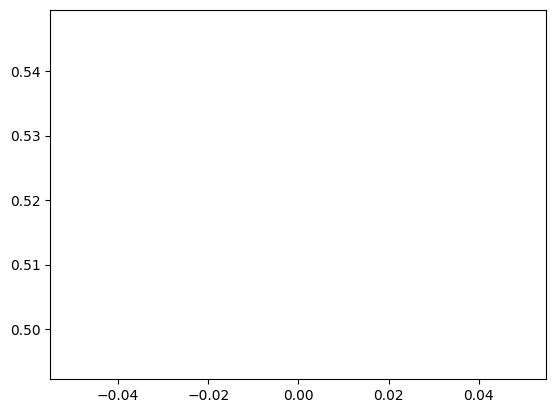

In [ ]:
plt.plot(lossi)

The hockey stick shape which was there initially is not there (which is good).now, the networks turns to training the net right from the scratch.

In [ ]:
@torch.no_grad() # decorator disables gradient tracking

def split_loss(split):
  x,y = {
      'train':(Xtr,Ytr),
      'dev':(Xdev,Ydev),
      'test':(Xte,Yte)
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0],-1)
  h = torch.tanh(embcat @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits,y)
  print(split, loss.item())

split_loss('train')
split_loss('dev')

train 3.2285635471343994
dev 3.228546380996704


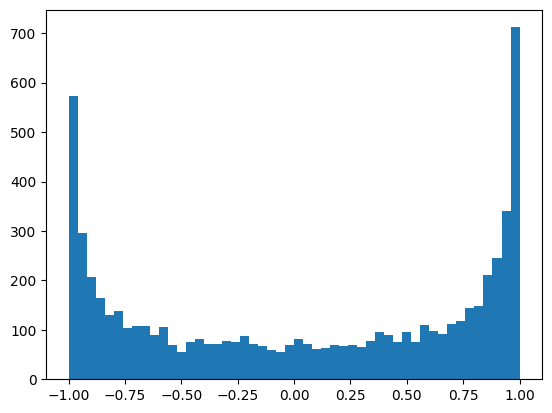

In [ ]:
plt.hist(h.view(-1).tolist(),50);

the values are all centered around -1 and 1 which are the min and max values of tanh activation function. This is bad news, the values are all getting saturated, and this might affect the gradients. the gradient of tanh is directly proportional to (1-t**2), where t is the output and if t is 1 or -1, gradient turns 0 and hence no training possible


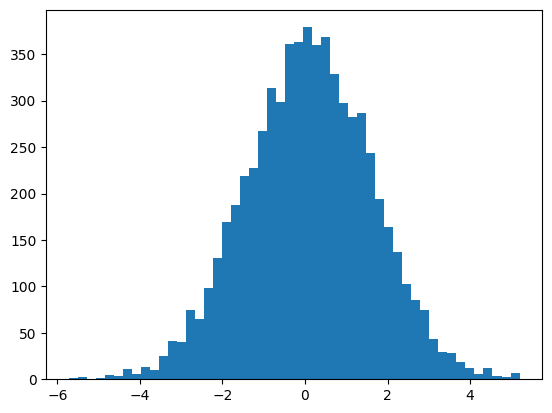

In [ ]:
plt.hist(hpreact.view(-1).tolist(),50);

hpreact is within the range [-20,20] like a Gaussian function

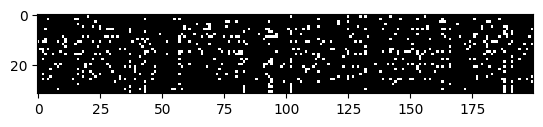

In [ ]:
plt.imshow(h.abs() > 0.99, interpolation='nearest', cmap='gray')

the white spaces show that the tanh values are in tails, through which gradients cannot flow back,if for any neuron, if all the 32 rows have whitespaces, it means that the neuron is a dead neuron, hence there is no learning, in this example , there is no such thing and hence training happens , i believe

to solve this problem , we start from hpreact, we see that the values are distanced out(i.e high variance), so we need them to be as close to zero as possible ,this makes tanh to not saturate at -1 or 1.

This random initialization works fine for shallow network like the above one, when we go for networks which are deeper like 50 layers deep, we can run into all sorts of problems, so smart initialization becomes compulsory
Andrej video : 31 mins

mean of x :  tensor(-0.0123)
mean of y :  tensor(0.0023)
std of x :  tensor(1.0005)
std of y :  tensor(1.0162)


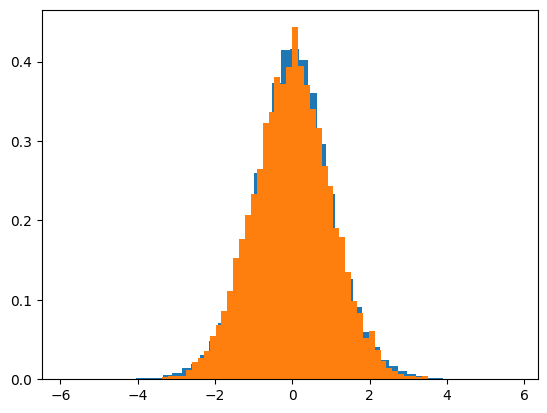

In [ ]:
x = torch.randn(1000,10)
w = torch.randn(10,200)/10**0.5
y = x @ w

print("mean of x : ", x.mean())
print("mean of y : ", y.mean())

print("std of x : ", x.std())
print("std of y : ", y.std())

plt.hist(y.view(-1).tolist(),50,density=True);
plt.hist(x.view(-1).tolist(),50,density=True);

To prevent this shift in covariance, there are some tricks.one is the weights could be divided by a factor sqrt(number of input neurons), this makes sure that variance is 1.
the gain values for preserving the variance across layers changes for different activations functions, for example for tanh it is 5/3,for relu it is sqrt(2) etc
nowadays, with advancements like batch-normalizations, adam optimiser(and other advanced optimizers), residual neural nets etc, there is no need for specialized tuning of gains, initializations etc.
useful pytorch link : https://pytorch.org/docs/stable/nn.init.html



```
# This is formatted as code
```

Batch normalization : A very important innovation offering stability to trainig neural nets

In [ ]:
hpreact.mean(dim=0,keepdim=True).shape

torch.Size([1, 200])

In [ ]:
num_embed = 10 # length of embedding vector
num_hidden = 200 # size of the hidden layer

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, num_embed), generator=g)
W1 = torch.randn((num_embed*block_size, num_hidden),generator=g)* (5/3) / math.sqrt(num_embed*block_size)
b1 = torch.randn(num_hidden , generator=g)*0.01
#the logits are all higher values which lead to big initial loss, to reduce the initial loss to
#respectable level, logits are to be made as close to zero as possible, so, b2 = 0 and w2 is close to zero
#but not zero.
W2 = torch.randn((num_hidden, vocab_size),generator=g)*0.01
b2 = torch.randn(vocab_size, generator=g)*0

#Batchnorm parameters initialization
bngain = torch.ones((1,num_hidden))
bnbias = torch.zeros((1,num_hidden))

#running mean and std for entire training set
bnmean_running = torch.zeros((1,num_hidden))
bnstd_running = torch.ones((1,num_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad=True


12297


batch normalization is fine for normalization but while training it beter to allow the backprop to modify the distribution of weights , so we put in two trainable parameters bngain and bnbias to shift and scale the parameters

In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  ix = torch.randint(0,Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  emb = C[Xb]
  embcat = emb.view(emb.shape[0],-1)
  hpreact = embcat @ W1 + b1
  bnmeani = hpreact.mean(dim=0,keepdim=True)
  bnstdi = hpreact.std(dim=0,keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

  h = torch.tanh(hpreact)

  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)

  with torch.no_grad():
    bnmean_running = 0.999*bnmean_running + 0.001*bnmeani
    bnstd_running = 0.999*bnstd_running + 0.001*bnstdi



  for p in parameters:
    p.grad = None

  loss.backward()

  lr = 0.1 if i <= 100000 else 0.01

  for p in parameters:
    p.data += -lr*p.grad

  if i % 10000 == 0 :
    print (f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3011
 120000/ 200000: 1.9833
 130000/ 200000: 2.4523
 140000/ 200000: 2.3840
 150000/ 200000: 2.1990
 160000/ 200000: 1.9731
 170000/ 200000: 1.8669
 180000/ 200000: 1.9974
 190000/ 200000: 1.8347


Addition of batch norm has a secondary effect as well. earlier the hpreact and logits were dependent only on one one input example [though they were processed in batches] , now, as we are calculating mean of batches and stddev as well, we are introducing the contributions from other examples as well which creates jitter in the logits. this may seem bad at first, but this has a positive secondary effect , it introduces regularization through data augmentation which makes it harder for the model to overfit

there is also another problem to discuss - while training data is processed in batches, meaning that we have access to batch data to calculate mean and stdd. but during inference, we feed data one by one, so the solution proposed is to calculate mean and std for entire training data and use it during inference.

this is done by calculating running mean and std.

In [ ]:
@torch.no_grad() # decorator disables gradient tracking

def split_loss(split):
  x,y = {
      'train':(Xtr,Ytr),
      'dev':(Xdev,Ydev),
      'test':(Xte,Yte)
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0],-1)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits,y)
  print(split, loss.item())

split_loss('train')
split_loss('dev')

train 2.06659197807312
dev 2.10506010055542


there is another subtle issue here, we are calculating hpreact = embcat @ W1 + b1 and then subtracting hpreact with hpreact.mean(dim=0, keepdim=True), so b1 is subtracted and has no say in gradient calculation in training as well, so we may as well remove bias of a neuron if there is batchnorm afterwards. See below for the illustration

In [ ]:
num_embed = 10 # length of embedding vector
num_hidden = 200 # size of the hidden layer

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, num_embed), generator=g)
W1 = torch.randn((num_embed*block_size, num_hidden),generator=g)* (5/3) / math.sqrt(num_embed*block_size)
#b1 = torch.randn(num_hidden , generator=g)*0.01
#the logits are all higher values which lead to big initial loss, to reduce the initial loss to
#respectable level, logits are to be made as close to zero as possible, so, b2 = 0 and w2 is close to zero
#but not zero.
W2 = torch.randn((num_hidden, vocab_size),generator=g)*0.01
b2 = torch.randn(vocab_size, generator=g)*0

#Batchnorm parameters initialization
bngain = torch.ones((1,num_hidden))
bnbias = torch.zeros((1,num_hidden))

#running mean and std for entire training set
bnmean_running = torch.zeros((1,num_hidden))
bnstd_running = torch.ones((1,num_hidden))

parameters = [C, W1,  W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad=True


12097


In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  ix = torch.randint(0,Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  emb = C[Xb]
  embcat = emb.view(emb.shape[0],-1)
  hpreact = embcat @ W1 #+ b1
  bnmeani = hpreact.mean(dim=0,keepdim=True)
  bnstdi = hpreact.std(dim=0,keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

  h = torch.tanh(hpreact)

  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)

  with torch.no_grad():
    bnmean_running = 0.999*bnmean_running + 0.001*bnmeani
    bnstd_running = 0.999*bnstd_running + 0.001*bnstdi



  for p in parameters:
    p.grad = None

  loss.backward()

  lr = 0.1 if i <= 100000 else 0.01

  for p in parameters:
    p.data += -lr*p.grad

  if i % 10000 == 0 :
    print (f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3141
 120000/ 200000: 1.6416
 130000/ 200000: 1.9313
 140000/ 200000: 2.2230
 150000/ 200000: 2.0029
 160000/ 200000: 2.0994
 170000/ 200000: 2.4950
 180000/ 200000: 2.0199
 190000/ 200000: 2.1709


In [ ]:
@torch.no_grad() # decorator disables gradient tracking

def split_loss(split):
  x,y = {
      'train':(Xtr,Ytr),
      'dev':(Xdev,Ydev),
      'test':(Xte,Yte)
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0],-1)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits,y)
  print(split, loss.item())

split_loss('train')
split_loss('dev')

train 2.067417860031128
dev 2.1056721210479736


the factor 0.999 and 0.001 used in calculation of running mean is the momentum , for smaller batch size for convergence to actual training mean and std, it is necessary to take smaller momentum , whereas for larger batch sizes, the stats are usually similar, so momentum of 0.1 or so can be taken

Writing modular code similar to pytorch

In [ ]:
class Linear:
  def __init__(self,fan_in, fan_out,bias=True):
    self.weight = torch.randn(fan_in, fan_out,generator=g)/fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self,x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
  def __init__(self,dim,eps=1e-5, momentum=0.01):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self,x):
    if self.training:
      xmean = x.mean(dim=0,keepdim=True)
      xvar = x.var(dim=0,keepdim=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var

    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma*xhat + self.beta

    if self.training:
      with torch.no_grad():
        self.running_mean = (1-self.momentum)*self.running_mean + self.momentum*xmean
        self.running_var = (1-self.momentum)*self.running_var + self.momentum*xvar
    return self.out

  def parameters(self):
    return [self.gamma,self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []









In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
#layers = [
#  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
 # Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
 # Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
 # Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
#]
layers = [
   Linear(n_embd * block_size, n_hidden), Tanh(),
   Linear(           n_hidden, n_hidden), Tanh(),
   Linear(           n_hidden, n_hidden), Tanh(),
   Linear(           n_hidden, n_hidden), Tanh(),
   Linear(           n_hidden, n_hidden), Tanh(),
   Linear(           n_hidden, vocab_size),
 ]

with torch.no_grad():
  # last layer: make less confident
  #layers[-1].gamma *= 0.1
  layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3 # 5/3 #1.0

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

46497


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >=10000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2962
  10000/ 200000: 2.3341


layer 0 (    Linear): mean -0.15, std 1.95, saturated: 62.56%
layer 2 (    Linear): mean -0.06, std 1.81, saturated: 63.09%
layer 4 (    Linear): mean -0.02, std 1.92, saturated: 66.69%
layer 6 (    Linear): mean -0.08, std 1.98, saturated: 70.31%
layer 8 (    Linear): mean +0.00, std 1.61, saturated: 54.81%


Text(0.5, 1.0, 'activation distribution')

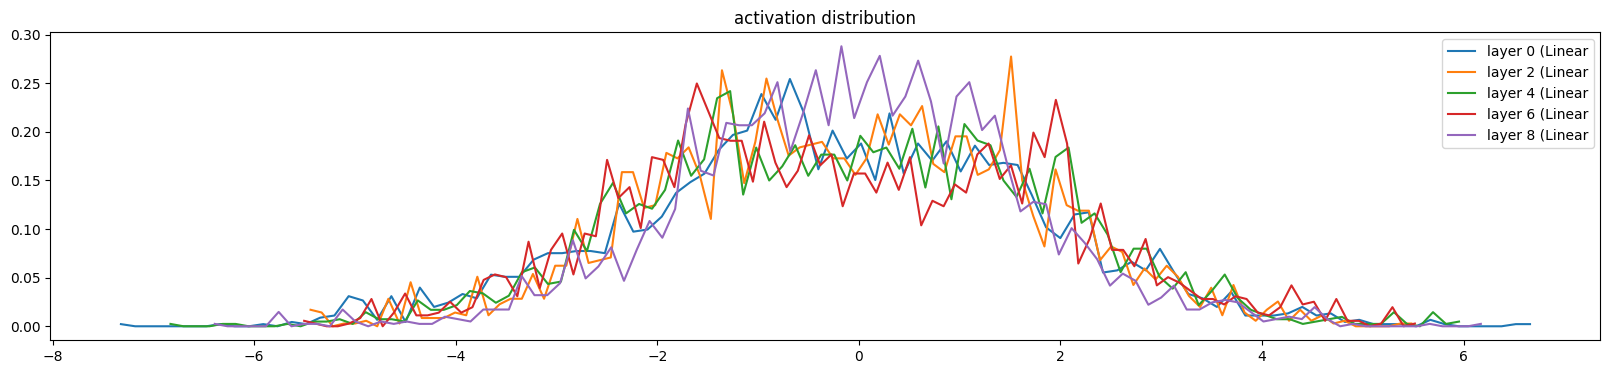

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Linear):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 0 (    Linear): mean -0.000026, std 1.821489e-03
layer 2 (    Linear): mean -0.000049, std 1.667478e-03
layer 4 (    Linear): mean +0.000006, std 1.581435e-03
layer 6 (    Linear): mean -0.000025, std 1.560461e-03
layer 8 (    Linear): mean -0.000029, std 1.650332e-03


Text(0.5, 1.0, 'gradient distribution')

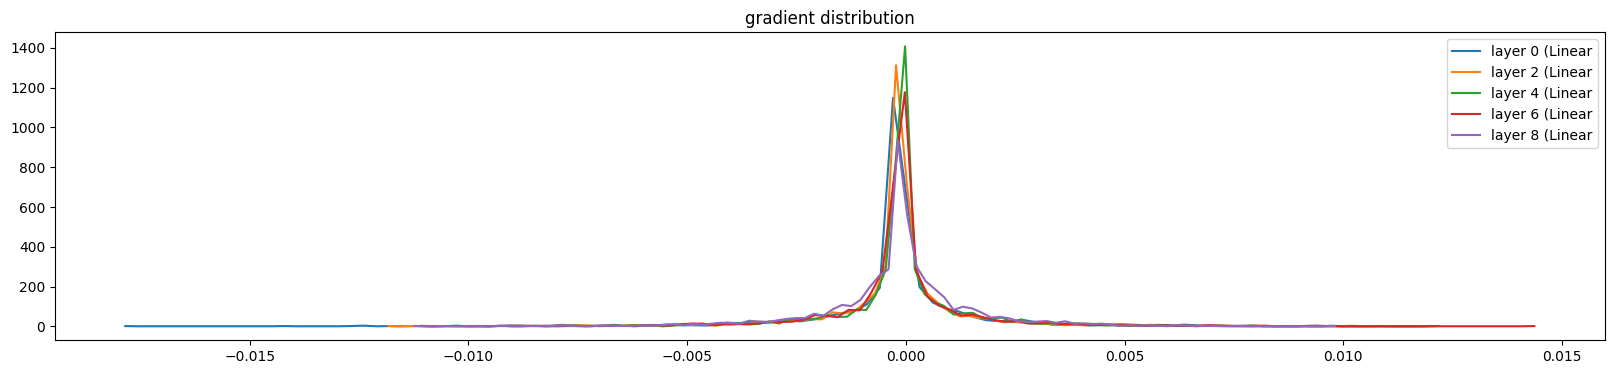

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Linear):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

the tanh activation function basically squishes the range of outputs - so, to initialize the weights of the linear layer before tanh layer, 5/3 is multiplied to push the distribution back to uniform distribution to make it have zero mean and the stddev of around 1.

Now , again if tanh is removed and only with linear layers, we put gain above 1, the uniform distribution parameters are distrubed resulting in gradients going to zero in the backward prop or blowing to higher value.

the activation function helps turn a linear function to a neural network which can approximate any function.

weight   (27, 10) | mean -0.001233 | std 1.225037e-02 | grad:data ratio 1.184498e-02
weight  (30, 100) | mean -0.000132 | std 1.050131e-02 | grad:data ratio 3.143758e-02
weight (100, 100) | mean +0.000206 | std 7.256098e-03 | grad:data ratio 3.883573e-02
weight (100, 100) | mean +0.000074 | std 6.819779e-03 | grad:data ratio 3.677147e-02
weight (100, 100) | mean -0.000031 | std 6.697463e-03 | grad:data ratio 3.647922e-02
weight (100, 100) | mean +0.000079 | std 7.489445e-03 | grad:data ratio 4.257298e-02
weight  (100, 27) | mean +0.000000 | std 2.253908e-02 | grad:data ratio 1.941683e-01


Text(0.5, 1.0, 'wights gradient distribution')

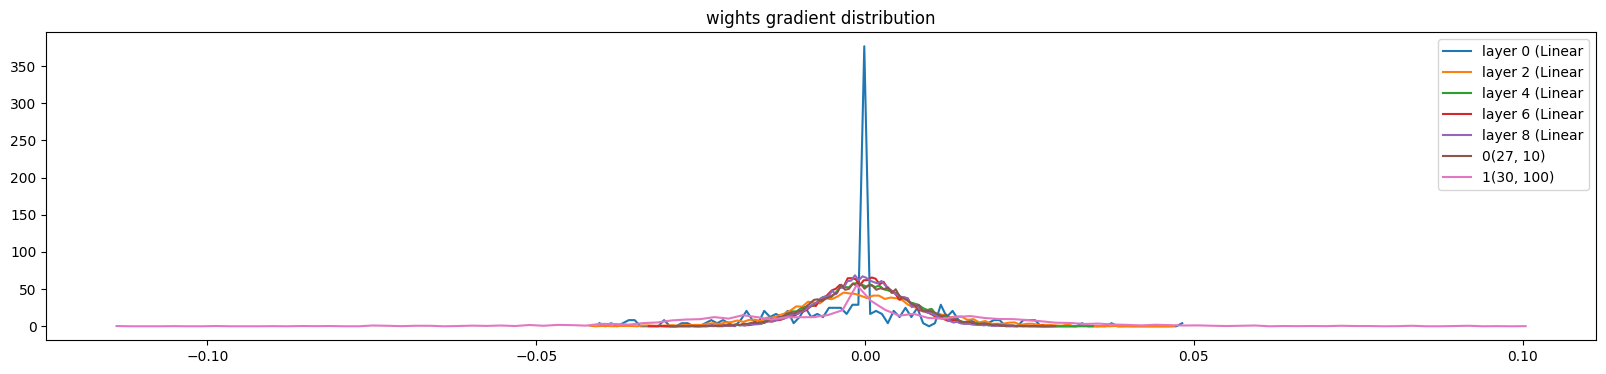

In [ ]:
#Let us visualize the weights a bit to understand how they change
plt.figure(figsize=(20,4))
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy,hx = torch.histogram(t,density=True)
    plt.plot(hx[:-1].detach(),hy.detach())
    legends.append(f'{i}{tuple(p.shape)}')
plt.legend(legends)
plt.title('wights gradient distribution')


The last layer weight distribution and gradient activation seem troublesome, the grad/data ratio is very large for the last layer , because at initialization, the last layer alone does 10 times forward/backward passes. But they somewhat adjust for themselves and grad/data ratio settles after say 1000 steps

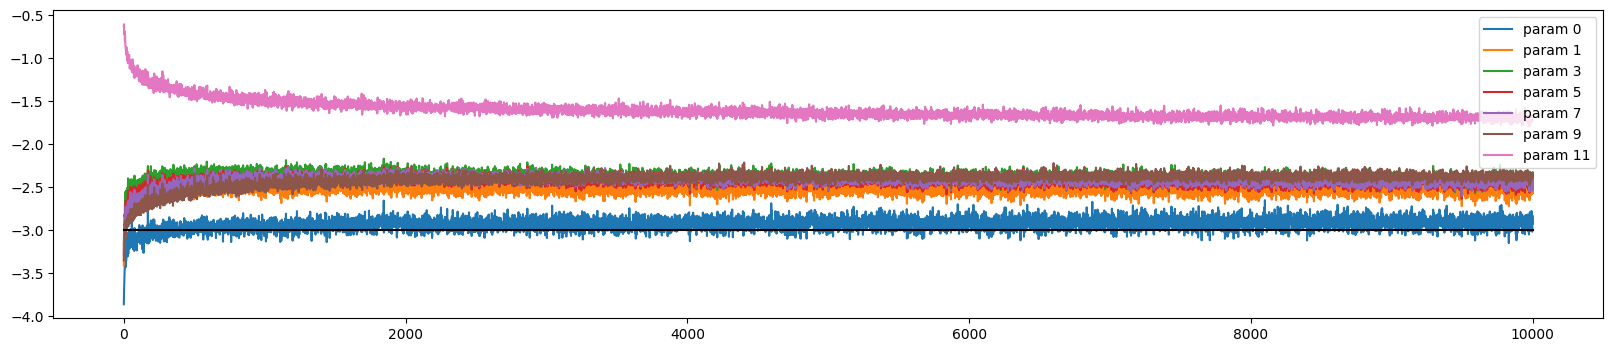

In [ ]:
#let us plot ud as well which is the update happening in the weights : lr*grad/data's std

plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0,len(ud)], [-3,-3], 'k')
plt.legend(legends)

the reason the final layers looks like a outlier is because the last layer was weights were made less confident by putting w = 0.1*w, this way the ratio of grad/weights is very unstable and high. a good thumb rule is to keep the update ratio close to -3 line, if it is too low, then learning is too slow

now let us have a look at the plots again with batchnorm introduced into the picture. What happens is that the saturation problem is taken care of bu the batchnorm 1-d and thus we get plots as expected without doing any parameter tuning


In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
'''
layers = [
   Linear(n_embd * block_size, n_hidden), Tanh(),
   Linear(           n_hidden, n_hidden), Tanh(),
   Linear(           n_hidden, n_hidden), Tanh(),
   Linear(           n_hidden, n_hidden), Tanh(),
   Linear(           n_hidden, n_hidden), Tanh(),
   Linear(           n_hidden, vocab_size),
 ]
'''
with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3 # 5/3 #1.0

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >=1:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2870


layer 0 (    Linear): mean -0.04, std 1.67, saturated: 56.78%
layer 3 (    Linear): mean +0.00, std 1.03, saturated: 36.53%
layer 6 (    Linear): mean +0.01, std 1.10, saturated: 37.22%
layer 9 (    Linear): mean -0.00, std 1.06, saturated: 36.50%
layer 12 (    Linear): mean -0.00, std 1.09, saturated: 37.59%
layer 15 (    Linear): mean +0.00, std 1.04, saturated: 37.15%


Text(0.5, 1.0, 'activation distribution')

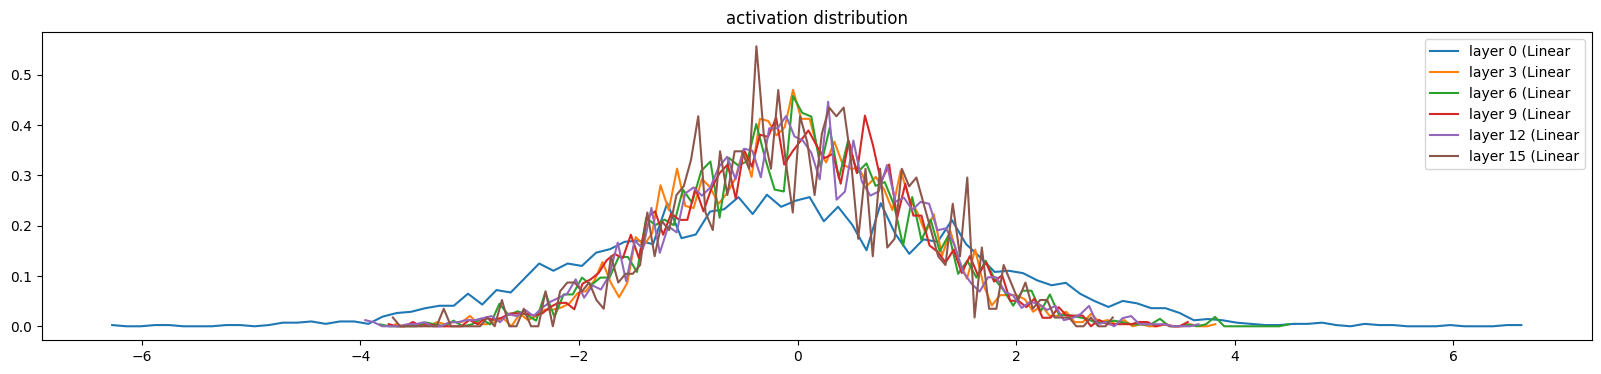

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Linear):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 0 (    Linear): mean +0.000000, std 4.062006e-04
layer 3 (    Linear): mean +0.000000, std 5.104265e-04
layer 6 (    Linear): mean -0.000000, std 4.321118e-04
layer 9 (    Linear): mean -0.000000, std 3.691000e-04
layer 12 (    Linear): mean +0.000000, std 3.291303e-04
layer 15 (    Linear): mean +0.000000, std 5.709725e-04


Text(0.5, 1.0, 'gradient distribution')

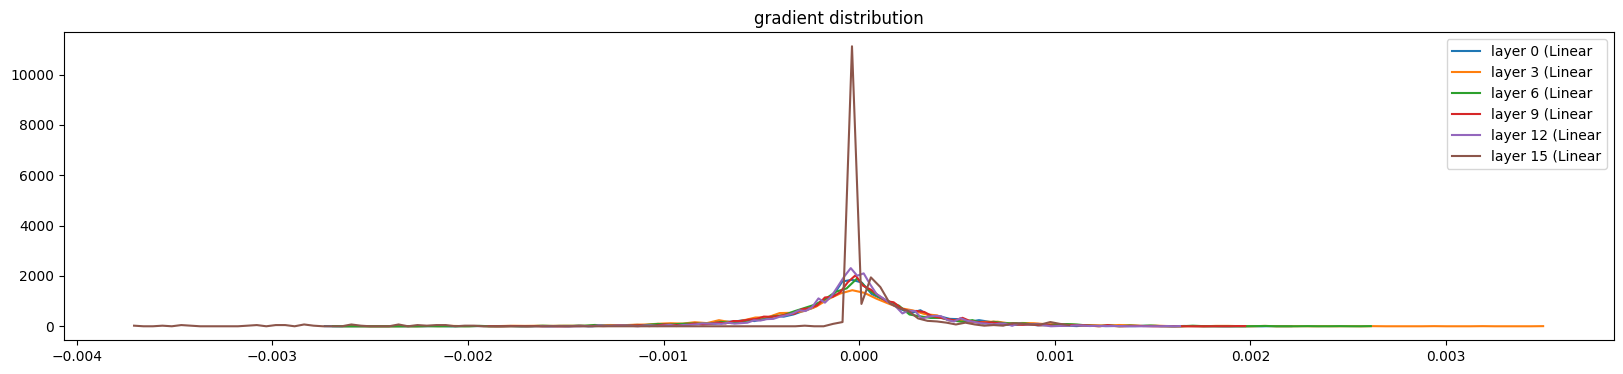

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Linear):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 1.845517e-03 | grad:data ratio 1.844182e-03
weight  (30, 100) | mean -0.000006 | std 1.925513e-03 | grad:data ratio 6.174217e-03
weight (100, 100) | mean +0.000019 | std 1.802429e-03 | grad:data ratio 1.085012e-02
weight (100, 100) | mean -0.000013 | std 1.524942e-03 | grad:data ratio 9.083300e-03
weight (100, 100) | mean +0.000006 | std 1.332303e-03 | grad:data ratio 7.969195e-03
weight (100, 100) | mean +0.000001 | std 1.287957e-03 | grad:data ratio 7.696474e-03
weight  (100, 27) | mean +0.000003 | std 2.249219e-03 | grad:data ratio 1.364947e-02


Text(0.5, 1.0, 'wights gradient distribution')

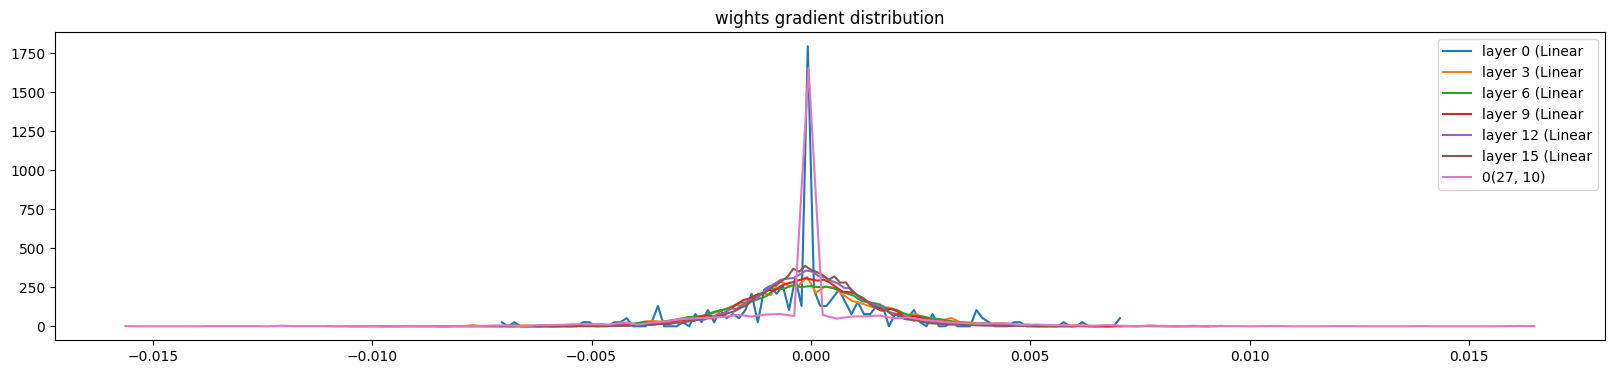

In [ ]:
#Let us visualize the weights a bit to understand how they change
plt.figure(figsize=(20,4))
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy,hx = torch.histogram(t,density=True)
    plt.plot(hx[:-1].detach(),hy.detach())
    legends.append(f'{i}{tuple(p.shape)}')
plt.legend(legends)
plt.title('wights gradient distribution')


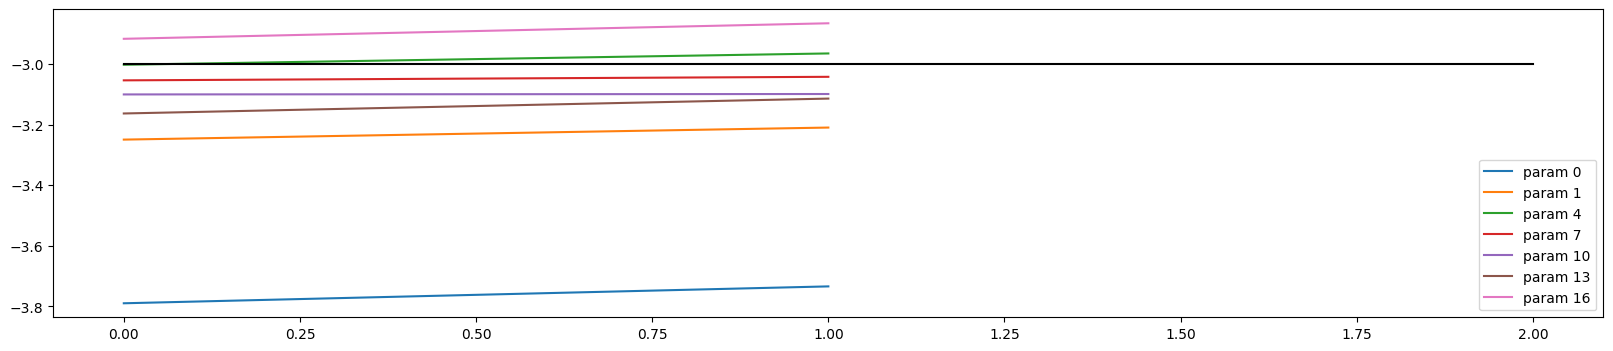

In [ ]:
#let us plot ud as well which is the update happening in the weights : lr*grad/data's std

plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0,len(ud)], [-3,-3], 'k')
plt.legend(legends)

we see that the plots are all fine due to this one single trick of batchnorm
even if we change the gain of weights from 5/3 to some arbitraty value, the training is still so going to be good, except for the last plot - the update ratio [this is affected due to the gain]. we could even remove the normalization by fan_in and the batch normalization will still work well, the learning rate may have to be adjusted.

more work is required to understand neural network initilization - for now , there are diagnostic tools to understand the weight update, gradient update and the ideas is to look at those plots and figure how to make them better. More work pending to gain an intuitive understanding of the weight activations, etc and how they behave layer by layer .

The network training is more stable now with batchnorm , but there was not much improvement in the performance as we will see, maybe becasue the bottleneck for performance is not the saturation of nonlinearity activations, but the context length and maybe not so powerful architecture

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 3.298459529876709
val 3.2975473403930664


sampling from the model:



In [ ]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor([context])]
    x = emb.view(emb.shape[0],-1)
    for layer in layers:
      x = layer(x)
    logits = x
    probs = F.softmax(logits,dim=1)
    ix = torch.multinomial(probs,num_samples=1,generator=g).item()

    context = context[1:] + [ix]

    out.append(ix)

    if ix == 0 :
      break
  print(''.join(itos[i] for i in out))






erbaagmyazzhzevvndhfyalwqetvrsjejdrljg.
ozcjedgeliihsmpqppalekepxvqnpxarqeptzcmhvqrpcnjszdbvrgxhgmjestkjcjrwjkjqqxntpucfkubzmgvdtrxyqqufmehg.
kmejqvskkydmzhjl.
cakyybsufpzbjglvjurenjcrtvwsvevoecmpfhdxrfqnxoeobhggptixjsfcueywwkhmrjolbidgqiiffwvpkxwvlla.
ortabfsztkndgoizvsblitgfkxvbssivpu.
meewrkepxcmvy.
xavttudkjgczekhgkgtipvtudt.
iwbddihzvorlq.
cjakepxugniagcfpppfmiipzjgvonxet.
jydnblkskfporygvogzvmwosfzpbsyknvmjcxtknvjb.
u.
jtew.
aow.
copmrlxkgdcqbcep.
ccdfibsnipimhtecmosagouwzlrurdckuppomtcokwxtnbnzkdphfam.
xcojfffuncxkhosy.
sj.
ascnpc.
cilwtanczhndtebimm.
ynw.


BatchNorm as widget:



In [ ]:
from ipywidgets import interactive,interact,fixed,interact_manual
import ipywidgets as widgets
import scipy.stats as stats
